# Tracking model
## Intro
The cascade model has been very informative for understanding how to use circuit models for flexible sensorimotor timing. Here we attempt to determine if such a model could be used to track a dynamic stimulus, _y_, where the value of _y_ is represented by an array of 'units', _x<sub>n</sub>_ and sensory information about the value of _y_ is only available intermitantly to update the otherwise internal representation.

#### Import libraries

In [1]:
# External code
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize
import os
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import animation, rc
from IPython.display import HTML

# NoisyMutualInhibition modules
import simulation_module as sim

%matplotlib inline

#### Definte parameters



In [2]:
# Common parameters used for the entire file
epsi = 0.01
param_dict = {'Winh': np.matrix('0 -1 -0.5 -1; -1 0 -1 -0.5; -0.5 -1 0 -1; -1 -0.5 -1 0')*10,
              'Wexc': np.matrix('0  0 0 1.5; 1.5 0 0 0; 0 1.5 0 0; 0 0 1.5 0')*10,
              'tau': 500, 'dt': 1}

x0 = np.matrix('0.8; 0.2; 0.2; 0.2')
I0 = 0.5


#### Define functions

In [3]:
def find_null_cline(x_vals, params):
    ''' For drawing the null clines'''
    Winh = params['Winh']
    Wexc = params['Wexc']
    theta = params['theta']
    return 1 / (1  + np.exp(Winh * x_vals - Wexc * x_vals))


def RingMovie(x,scale):
    fig, ax = plt.subplots()
    ax.set_xlim((-2,2))
    ax.set_ylim((-2,2))
    ax.set_aspect('equal', 'box')
    pos = np.ones((x.shape[0],2))
    szs = np.ones((x.shape[0]))
    cs = np.ones((x.shape[0]))
    thetas = np.linspace(0,360-360/x.shape[0],x.shape[0])
    for i in range(x.shape[0]):
        pos[i,0] = np.sin(np.deg2rad(thetas[i]))
        pos[i,1] = np.cos(np.deg2rad(thetas[i]))
        szs[i] = x[i,0]*scale
        cs[i] = x[i,0]
    scat = plt.scatter(pos.T[0,],pos.T[1,], s=100, c=cs)
    ani = animation.FuncAnimation(fig, animate, frames = x.shape[1],
                                 fargs=(x, scat), blit=False, interval=2)
    return ani

def animate(i, data, scat):
    scat.set_array(np.array(data.T[i,]))

#### Initial simulation
As a proof of concept, run the units and determine if they make a chain of activation.

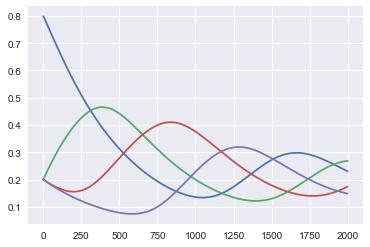

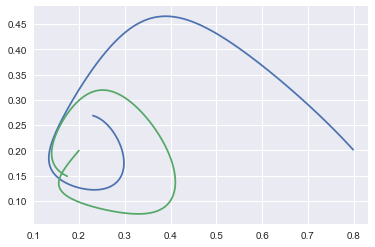

In [4]:
    
x_lst = sim.simulate_x(x0, I0, param_dict, niter=2000)
plt.figure
plt.plot(np.asarray(x_lst.T))
#plt.plot(np.asarray(x_lst[0,].T))
#plt.plot(np.asarray(x_lst[1,].T))
#plt.plot(np.asarray(x_lst[2,].T))
#plt.plot(np.asarray(x_lst[3,].T))
plt.show()

plt.figure
plt.plot(np.asarray(x_lst[0,].T),np.asarray(x_lst[1,].T))
plt.plot(np.asarray(x_lst[2,].T),np.asarray(x_lst[3,].T))
plt.show()

### 8-node network
Ok, the proof of concept worked! Now let's expand that to 8 nodes. We'll need to also expand the inhibitory footprint, with each unit inhibiting all the others with a decreasing weight as a function of distance.

#### Reset weigth matrices

In [5]:
param_dict = {'Winh': np.matrix('0 -1 -0.6 -0.4 -0.4 -0.4 -0.6 -1; -1 0 -1 -0.6 -0.4 -0.4 -0.4 -0.6; -0.6 -1 0 -1 -0.6 -0.4 -0.4 -0.4; -0.4 -0.6 -1 0 -1 -0.6 -0.4 -0.4; -0.4 -0.4 -0.6 -1 0 -1 -0.6 -0.4; -0.4 -0.4 -0.4 -0.6 -1 0 -1 -0.6; -0.6 -0.4 -0.4 -0.4 -0.6 -1 0 -1; -1 -0.6 -0.4 -0. -0.4 -0.6 -1 0')*10,
              'Wexc': np.matrix('0 0 0 0 0 0 0 1; 1 0 0 0 0 0 0 0; 0 1 0 0 0 0 0 0; 0 0 1 0 0 0 0 0; 0 0 0 1 0 0 0 0; 0 0 0 0 1 0 0 0; 0 0 0 0 0 1 0 0; 0 0 0 0 0 0 1 0')*10*2,
              'tau': 500, 'dt': 1}

x0 = np.matrix('0.8; 0.2; 0.2; 0.2; 0.2; 0.2; 0.2; 0.2')
I0 = 2

#### Simulate results

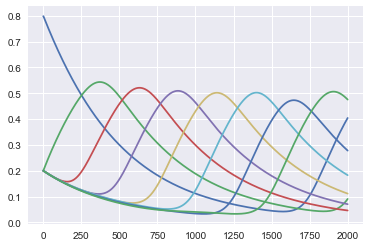

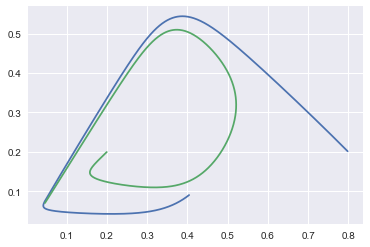

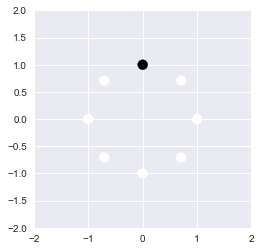

In [6]:
x_lst = sim.simulate_x(x0, I0, param_dict, niter=2000)
plt.figure
plt.plot(np.asarray(x_lst.T))
#plt.plot(np.asarray(x_lst[0,].T))
#plt.plot(np.asarray(x_lst[1,].T))
#plt.plot(np.asarray(x_lst[2,].T))
#plt.plot(np.asarray(x_lst[3,].T))
plt.show()

plt.figure
plt.plot(np.asarray(x_lst[0,].T),np.asarray(x_lst[1,].T))
plt.plot(np.asarray(x_lst[2,].T),np.asarray(x_lst[3,].T))
plt.show()

x = np.array(x_lst)
ani = RingMovie(x,200)
HTML(ani.to_html5_video())

Now lets see if input controls speed. First lets _increase_ the input level

In [7]:
param_dict = {'Winh': np.matrix('0 -1 -0.6 -0.4 -0.4 -0.4 -0.6 -1; -1 0 -1 -0.6 -0.4 -0.4 -0.4 -0.6; -0.6 -1 0 -1 -0.6 -0.4 -0.4 -0.4; -0.4 -0.6 -1 0 -1 -0.6 -0.4 -0.4; -0.4 -0.4 -0.6 -1 0 -1 -0.6 -0.4; -0.4 -0.4 -0.4 -0.6 -1 0 -1 -0.6; -0.6 -0.4 -0.4 -0.4 -0.6 -1 0 -1; -1 -0.6 -0.4 -0. -0.4 -0.6 -1 0')*10,
              'Wexc': np.matrix('0 0 0 0 0 0 0 1; 1 0 0 0 0 0 0 0; 0 1 0 0 0 0 0 0; 0 0 1 0 0 0 0 0; 0 0 0 1 0 0 0 0; 0 0 0 0 1 0 0 0; 0 0 0 0 0 1 0 0; 0 0 0 0 0 0 1 0')*10*2,
              'tau': 500, 'dt': 1}

x0 = np.matrix('0.8; 0.2; 0.2; 0.2; 0.2; 0.2; 0.2; 0.2')
I0 = 6

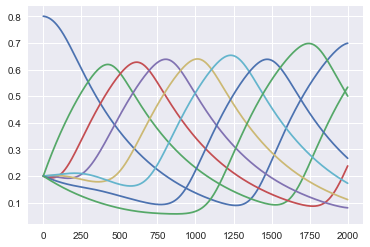

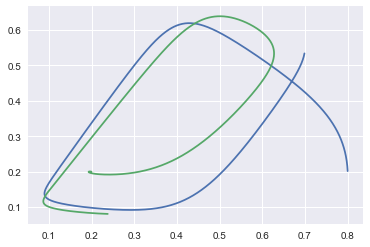

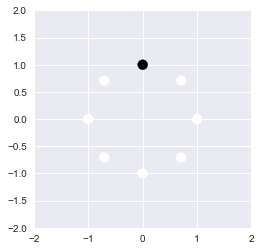

In [8]:
x_lst = sim.simulate_x(x0, I0, param_dict, niter=2000)
plt.figure
plt.plot(np.asarray(x_lst.T))
plt.show()

plt.figure
plt.plot(np.asarray(x_lst[0,].T),np.asarray(x_lst[1,].T))
plt.plot(np.asarray(x_lst[2,].T),np.asarray(x_lst[3,].T))
plt.show()

x = np.array(x_lst)
ani = RingMovie(x,200)
HTML(ani.to_html5_video())

That looks to have sped up the process. Now let's _decrease_ the input

In [9]:
param_dict = {'Winh': np.matrix('0 -1 -0.6 -0.4 -0.4 -0.4 -0.6 -1; -1 0 -1 -0.6 -0.4 -0.4 -0.4 -0.6; -0.6 -1 0 -1 -0.6 -0.4 -0.4 -0.4; -0.4 -0.6 -1 0 -1 -0.6 -0.4 -0.4; -0.4 -0.4 -0.6 -1 0 -1 -0.6 -0.4; -0.4 -0.4 -0.4 -0.6 -1 0 -1 -0.6; -0.6 -0.4 -0.4 -0.4 -0.6 -1 0 -1; -1 -0.6 -0.4 -0. -0.4 -0.6 -1 0')*10,
              'Wexc': np.matrix('0 0 0 0 0 0 0 1; 1 0 0 0 0 0 0 0; 0 1 0 0 0 0 0 0; 0 0 1 0 0 0 0 0; 0 0 0 1 0 0 0 0; 0 0 0 0 1 0 0 0; 0 0 0 0 0 1 0 0; 0 0 0 0 0 0 1 0')*10*2,
              'tau': 500, 'dt': 1}

x0 = np.matrix('0.8; 0.2; 0.2; 0.2; 0.2; 0.2; 0.2; 0.2')
I0 = 0

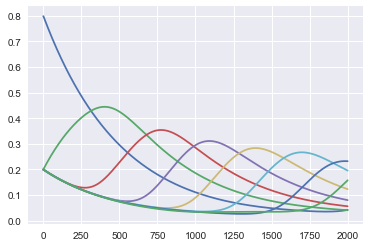

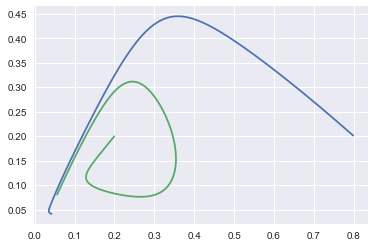

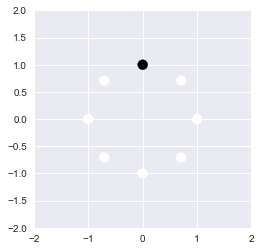

In [10]:
x_lst = sim.simulate_x(x0, I0, param_dict, niter=2000)
plt.figure
plt.plot(np.asarray(x_lst.T))
plt.show()

plt.figure
plt.plot(np.asarray(x_lst[0,].T),np.asarray(x_lst[1,].T))
plt.plot(np.asarray(x_lst[2,].T),np.asarray(x_lst[3,].T))
plt.show()

x = np.array(x_lst)
ani = RingMovie(x,200)
HTML(ani.to_html5_video())

That looks like it slowed the process. In general, it looks like we have a simple circuit that will run forward at different speeds based on the level of input.

#### Update function?
To make this work, we have to get an effective error signal out of the network that tells it how much to change its input to match the object's speed. Based on the cascade model, such a signal might be recoverable from the difference in activation of two units:

_Error_ = _x<sub>n</sub>_ - _x<sub>n-1</sub>_

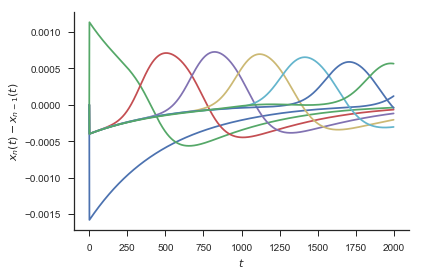

In [11]:
dx = np.diff(x_lst,1,1)
plt.figure
sns.set_style("white") 
sns.set_style("ticks")
plt.plot(np.asarray(dx.T))
sns.despine()
plt.xlabel('$t$')
plt.ylabel('$x_n(t) - x_{n-1}(t)$')
plt.show()




The difference in the state of adjacent units does indeed seem to serve as an error function. We'll return to this once we look at how the network responds to new initial conditions.

#### Response to position feedback
We will model a new input into the system as setting the component that is associated with the input to a high level, but keeping the coditions of the other nodes the same. First, lets run the simulation forward from x_1 for 1000 time steps.

In [25]:
param_dict = {'Winh': np.matrix('0 -1 -0.6 -0.4 -0.4 -0.4 -0.6 -1; -1 0 -1 -0.6 -0.4 -0.4 -0.4 -0.6; -0.6 -1 0 -1 -0.6 -0.4 -0.4 -0.4; -0.4 -0.6 -1 0 -1 -0.6 -0.4 -0.4; -0.4 -0.4 -0.6 -1 0 -1 -0.6 -0.4; -0.4 -0.4 -0.4 -0.6 -1 0 -1 -0.6; -0.6 -0.4 -0.4 -0.4 -0.6 -1 0 -1; -1 -0.6 -0.4 -0. -0.4 -0.6 -1 0')*10,
              'Wexc': np.matrix('0 0 0 0 0 0 0 1; 1 0 0 0 0 0 0 0; 0 1 0 0 0 0 0 0; 0 0 1 0 0 0 0 0; 0 0 0 1 0 0 0 0; 0 0 0 0 1 0 0 0; 0 0 0 0 0 1 0 0; 0 0 0 0 0 0 1 0')*10*2,
              'tau': 500, 'dt': 1}

x0 = np.matrix('0.8; 0.2; 0.2; 0.2; 0.2; 0.2; 0.2; 0.2')
I0 = 1

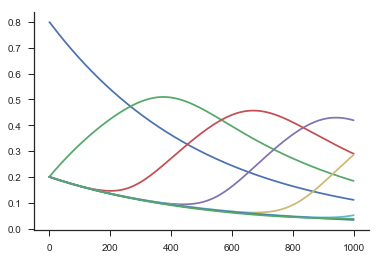

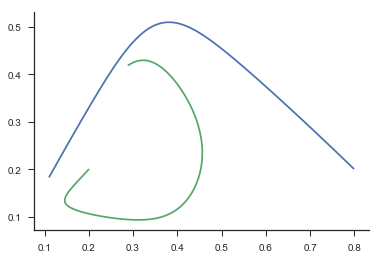

In [13]:
x_lst = sim.simulate_x(x0, I0, param_dict, niter=1000)
plt.figure
plt.plot(np.asarray(x_lst.T))
sns.despine()
plt.show()

plt.figure
plt.plot(np.asarray(x_lst[0,].T),np.asarray(x_lst[1,].T))
plt.plot(np.asarray(x_lst[2,].T),np.asarray(x_lst[3,].T))
sns.despine()
plt.show()

Now lets set x0 to x[1000,], except the 3rd node will be set high.

In [14]:
x0 = x_lst[...,1000];
x0[2] = 0.8
x0

matrix([[ 0.11078341],
        [ 0.18416758],
        [ 0.8       ],
        [ 0.41881981],
        [ 0.28534313],
        [ 0.05153747],
        [ 0.03324566],
        [ 0.03764214]])

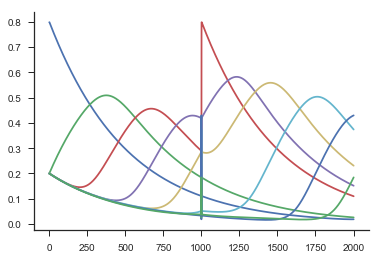

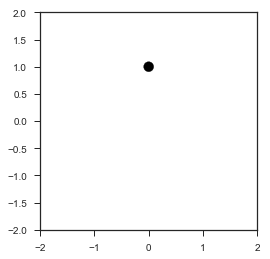

In [15]:
x_lst2 = sim.simulate_x(x0, I0, param_dict, niter=1000)
x_lst3 = np.concatenate((x_lst,x_lst2), axis=1)
x_lst3.shape
plt.figure
plt.plot(np.asarray(x_lst3.T))
sns.despine()
plt.show()

x = np.array(x_lst3)
ani = RingMovie(x,200)
HTML(ani.to_html5_video())

Now lets set x0 to x[1000,], except the 5th node will be set high.

In [16]:
x0 = x_lst[...,1000];
x0[6] = 0.8
x0

matrix([[ 0.01867812],
        [ 0.02602119],
        [ 0.10981555],
        [ 0.15144405],
        [ 0.23080458],
        [ 0.37395662],
        [ 0.8       ],
        [ 0.18444517]])

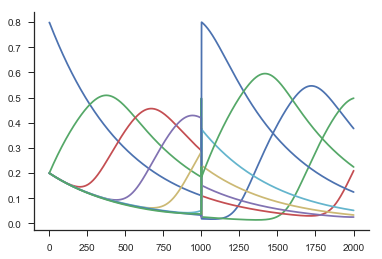

In [17]:
x_lst2 = sim.simulate_x(x0, I0, param_dict, niter=1000)
x_lst3 = np.concatenate((x_lst,x_lst2), axis=1)
x_lst3.shape
plt.figure
plt.plot(np.asarray(x_lst3.T))
sns.despine()
plt.show()

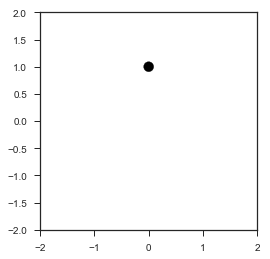

In [20]:
x = np.array(x_lst3)
ani = RingMovie(x,200)
HTML(ani.to_html5_video())

Ok, we can pretty easily reset the position and just keep things running in this set up.

### Putting it all together – update position and input
So far we have managed to run a simulation following an initial kick, telling the bump of activity where to start. Recurrent dynamics then drive the simulation forwrad. The speed of that simulation is controlled by input level (proportionally), get a sense of the error in simulation based on the activity level and the next position measurement, and we can update the position by reseting the activity of the correct unit to a high level.

Now we need to put these elements together to get a system that adapts input (and therefore speed) to better track the object.

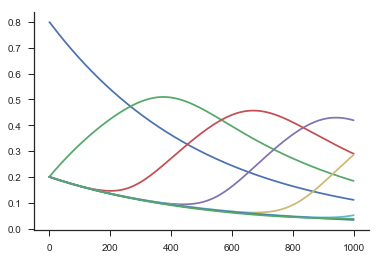

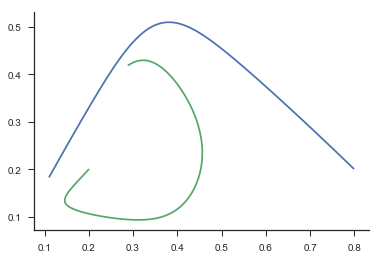

In [26]:
x_lst = sim.simulate_x(x0, I0, param_dict, niter=1000)
plt.figure
plt.plot(np.asarray(x_lst.T))
sns.despine()
plt.show()

plt.figure
plt.plot(np.asarray(x_lst[0,].T),np.asarray(x_lst[1,].T))
plt.plot(np.asarray(x_lst[2,].T),np.asarray(x_lst[3,].T))
sns.despine()
plt.show()

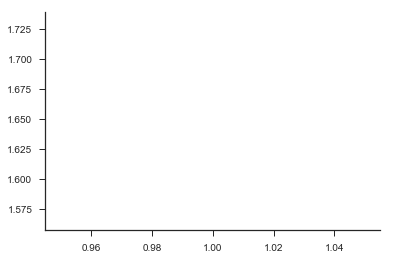

In [35]:
x0 = x_lst[...,1000]
x0[5] = 0.8
k = 1
I1 = I0 + k*(x_lst[5,1000] - x_lst[6,1000])
plt.figure
plt.plot(I0,I1)
sns.despine()
plt.show()

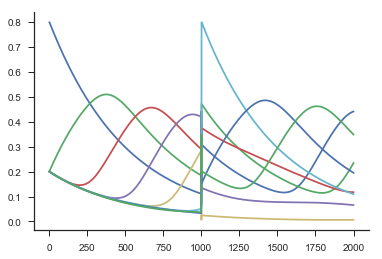

In [36]:
x_lst2 = sim.simulate_x(x0, I1, param_dict, niter=1000)
x_lst3 = np.concatenate((x_lst,x_lst2), axis=1)
x_lst3.shape
plt.figure
plt.plot(np.asarray(x_lst3.T))
sns.despine()
plt.show()

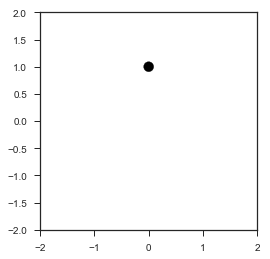

In [32]:
x = np.array(x_lst3)
ani = RingMovie(x,200)
HTML(ani.to_html5_video())